### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

### Solution

#### Part 1

In [2]:
import numpy as np

def hetero_gauss_mean(x_i, sigma):

    return np.sum(x_i/(sigma**2))/np.sum(1/(sigma**2))

def hetero_gauss_std_mean(sigma):

    return np.sqrt(1/np.sum(1/(sigma**2)))

    
data = np.load('../../../homeworks/hw_data/hw3_data_1.npy')

measurement = data[:,0]
uncertainty = data[:,1]

print("The mean using analytic results for heteroscedastic Gaussian:                   %.5f" % hetero_gauss_mean(measurement, uncertainty))
print("The standard error on mean using analytic results for heteroscedastic Gaussian: %.5f" % hetero_gauss_std_mean(uncertainty))

The mean using analytic results for heteroscedastic Gaussian:                   3.91799
The standard error on mean using analytic results for heteroscedastic Gaussian: 0.09481


#### Part 2

In [3]:
from scipy import optimize

def ln_lik_hetero_gauss(mu, sigma, x_i):

    return np.sum(np.log(2*np.pi*(sigma**2)) + (((x_i - mu)**2) / (sigma**2)))

trial_gauss = [np.mean(measurement), np.std(measurement)]

f_gauss = lambda t: ln_lik_hetero_gauss(t[0], t[1], x_i=measurement)

beta_gauss = optimize.fmin(f_gauss, trial_gauss)

print("The best fit mean: %.5f" % beta_gauss[0])

Optimization terminated successfully.
         Current function value: 311.865378
         Iterations: 21
         Function evaluations: 43
The best fit mean: 3.93755


#### Part 3

In [4]:
#fisher_sigma_mu = np.diff(ln_lik_hetero_gauss(mu=trial_gauss[0], sigma=trial_gauss[1], x_i=measurement), n=2)
#fisher_sigma_mu /= (measurement[1]-measurement[0])**2
#fisher_sigma_mu *= -1
#fisher_sigma_mu = 1/np.sqrt(fisher_sigma_mu)[0]

fisher_sigma_mu = np.sqrt(1/np.sum(1/(uncertainty**2)))

print("Fisher matrix error on estimated mean is %.5f" % fisher_sigma_mu)

Fisher matrix error on estimated mean is 0.09481


#### Part 4

In [5]:
def bootstrap(data, realizations):

    resampled_data = []
    
    for n in range(realizations):

        resampled_data.append(data[np.random.choice(len(data), size=len(data), replace=True), :])


    return resampled_data


bootstrap_data = bootstrap(data=data, realizations=1000)

#### Part 5

In [6]:
def get_dist_bootstrap(boot_data, realizations, laplace=False):
    
    b_fit_mean = []
    b_fit_std = []
    
    for n in range(realizations):
        
        t1 = np.mean(boot_data[n][:,0])
        t2 = np.std(boot_data[n][:,0])

        pars = [t1, t2]
        
        if laplace:
            f = lambda parameters: ln_lik_laplace(mu=parameters[0], delta=parameters[1], x_i=boot_data[n][:,0])
            
        else:
            f = lambda parameters: ln_lik_hetero_gauss(mu=parameters[0], sigma=parameters[1], x_i=boot_data[n][:,0]) #sigma=boot_data[n][:,1]
            
        b_fit_mean.append(optimize.fmin(f, pars)[0])
        b_fit_std.append(optimize.fmin(f, pars)[1])

    return b_fit_mean, b_fit_std

mean_dist_gauss, std_dist_gauss = get_dist_bootstrap(bootstrap_data, realizations=1000, laplace=False)

Optimization terminated successfully.
         Current function value: 324.838945
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 324.838945
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 328.374833
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 328.374833
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 304.469305
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 304.469305
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 296.631266
         Iterations: 21
         Function evaluations: 43
Optimization termina

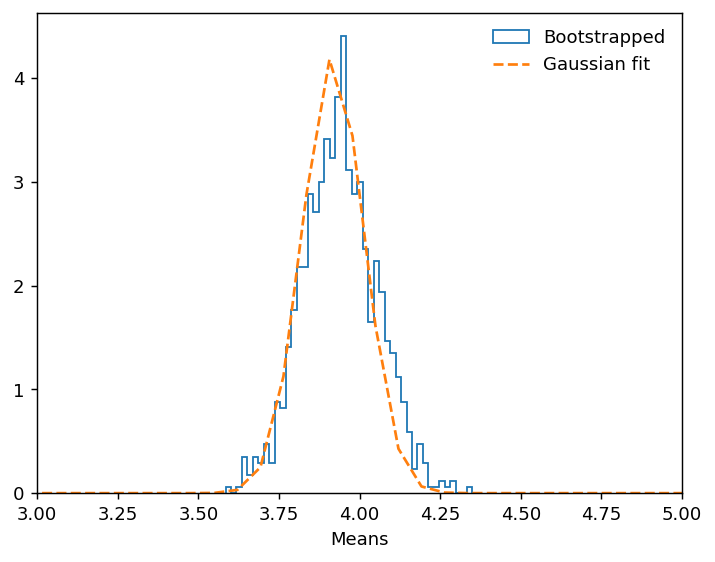

Yes it matches


In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm

xgrid = np.linspace(min(measurement), max(measurement), len(measurement))
gaussD = norm(loc=hetero_gauss_mean(measurement, uncertainty), scale=hetero_gauss_std_mean(uncertainty))

pdf = gaussD.pdf(xgrid)

plt.figure(dpi=130)
plt.hist(mean_dist_gauss, bins=45, histtype='step', density=True, label='Bootstrapped')#, normed=True)
plt.plot(xgrid, pdf, ls='--', label='Gaussian fit')
plt.xlim(3, 5)
plt.xlabel('Means')
plt.legend(frameon=False)
plt.show()

print("Yes it matches")

#### Part 6

In [8]:
def ln_lik_laplace(mu, delta, x_i):

    return ((len(x_i)*np.log(2*delta)) + (np.sum(np.abs(x_i - mu)) / delta))


trial_laplace = [np.mean(measurement), np.std(measurement)]

f_laplace = lambda t : ln_lik_laplace(mu=t[0], delta=t[1], x_i=measurement)

beta_laplace = optimize.fmin(f_laplace, trial_laplace)

print("The best fit location parameter using Laplace log likelihood: %.5f" % beta_laplace[0])
print("The best fit scale parameter using Laplace log likelihood: %.5f" % beta_laplace[1])

Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 45
         Function evaluations: 83
The best fit location parameter using Laplace log likelihood: 4.08533
The best fit scale parameter using Laplace log likelihood: 0.88227


#### Part 7

In [9]:
def aic(log_likelihood, k, N):

    return ((-2*log_likelihood) + (2*k) + ((2*k*(k+1))/(N-k-1)))

ln_lik_hetero_gauss_value = - ln_lik_hetero_gauss(mu=beta_gauss[0], sigma=uncertainty, x_i=measurement) #sigma=beta_gauss[1]
ln_lik_laplace_value = - ln_lik_laplace(mu=beta_laplace[0], delta=beta_laplace[1], x_i=measurement)

aic_heter_gauss = 0.5*aic(ln_lik_hetero_gauss_value, 2, len(measurement))
aic_laplace = aic(ln_lik_laplace_value, 2, len(measurement))

print("Max log-likelihood for Heteroscedastic Gaussian Model: %.5f " % ln_lik_hetero_gauss_value)
print("Max log-likelihood for Laplace Model:                  %.5f " % ln_lik_laplace_value)
print("\n")
print("AIC value for Heteroscedastic Gaussian Model:          %.5f " % aic_heter_gauss)
print("AIC value for Laplace Model:                           %.5f " % aic_laplace)
print("\n")
if aic_heter_gauss < aic_laplace:
    print("Heteroscedastic Gaussian Model is favoured by the data.")
else:
    print("Laplace Model is favoured by the data.")

Max log-likelihood for Heteroscedastic Gaussian Model: -294.55827 
Max log-likelihood for Laplace Model:                  -156.78892 


AIC value for Heteroscedastic Gaussian Model:          296.62012 
AIC value for Laplace Model:                           317.70154 


Heteroscedastic Gaussian Model is favoured by the data.


#### Part 8

In [10]:
import corner

mean_dist_laplace, std_dist_laplace = get_dist_bootstrap(bootstrap_data, realizations=1000, laplace=True)

Optimization terminated successfully.
         Current function value: 167.658994
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 167.658994
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 168.237841
         Iterations: 49
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 168.237841
         Iterations: 49
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 152.867747
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 152.867747
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 148.248805
         Iterations: 51
         Function evaluations: 97
Optimization termi

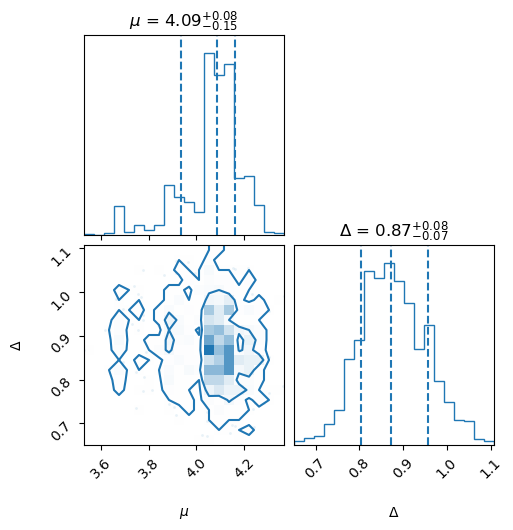

In [11]:
mean_dist_arr = np.array(mean_dist_laplace)
std_dist_arr = np.array(std_dist_laplace)

stacked_arr = np.column_stack([mean_dist_arr, std_dist_arr])

corner.corner(stacked_arr, labels=[r'$\mu$', r'$\Delta$'], levels=[0.68, 0.95], quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, color='tab:blue')
plt.show()

#### Part 9

In [12]:
import numdifftools as nd
from scipy.stats import laplace

def f_lnlaplace_funct(p, x_i):
    mu, delta = p
    return ((len(x_i)*np.log(2*delta)) + (np.sum(np.abs(x_i - mu)) / delta))

f_lnlaplace = lambda params: f_lnlaplace_funct(params, x_i=measurement)
 
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5
sigma_laplace

/var/folders/j1/3vly_rv96bj4npn_fhsf2ttw0000gn/T/ipykernel_5112/904849635.py:11: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(H)**0.5


array([[0.10922512,        nan],
       [       nan, 0.08822698]])

Yes, the diagonals elements corresponding to the mu and delta respectively matches with the upper widths in the corner plot above.